In [1]:
#Import etc
import cv2
import glob
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


files=glob.glob("Videos/*/*/")
#Print to check it seems ok
print(files)
print([i+"*.*" for i in  files])
filetree=[glob.glob(i+"*.*") for i in  files]
print(np.shape(filetree))
print(np.shape(filetree[0]))
print(np.shape(filetree[1]))


Populating the interactive namespace from numpy and matplotlib
['Videos/without/20180224_193809/', 'Videos/without/20180224_192617/', 'Videos/with/20180224_192237/', 'Videos/with/20180224_193623/']
['Videos/without/20180224_193809/*.*', 'Videos/without/20180224_192617/*.*', 'Videos/with/20180224_192237/*.*', 'Videos/with/20180224_193623/*.*']
(4,)
(1908,)
(4721,)


Videos/without/20180224_193809/frame01568.jpg


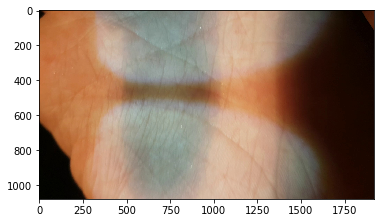

Videos/without/20180224_192617/frame04561.jpg


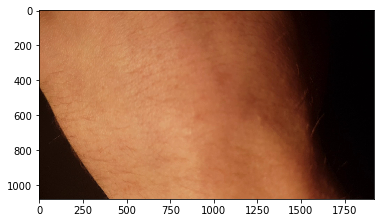

Videos/with/20180224_192237/frame00647.jpg


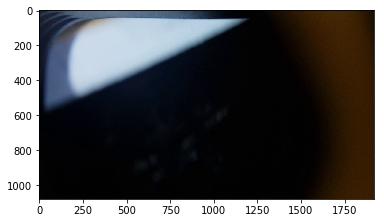

Videos/with/20180224_193623/frame01376.jpg


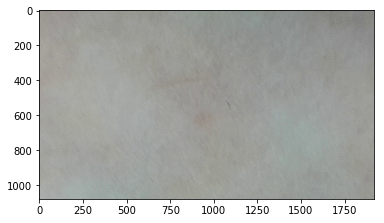

In [42]:
#show image examples
for images in filetree:
    image=np.random.choice(images)
    print(image)
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

In [44]:
# Sort the images from the 2 classes
hud=filetree[2]+filetree[3]
nohud=filetree[0]+filetree[1]
data=[(x,True) for x in hud] + [(x,False) for x in nohud]
data=sorted(data, key=lambda name: name[0])
#for d in data:
#    print(d)


In [46]:
# Split into training and test set, due to the fact we use a video as input, we don't want
# to just split randomly as it's too likily the test and training will bee too similar,  

train=[]
test=[]
r=data#list(range(16000))
start=0
while(start<len(r)):
    reminder=len(r)-start
    #print(reminder)
    length=reminder if reminder < 10 else np.random.randint(1,reminder if reminder < 400 else 400)
    #print(length)
    if len(train) == 0:
        train=train + r[start:start+length]
    elif len(test)/len(train)>2.5:
        train=train + r[start:start+length]
    else:
        test=test + r[start:start+length]
    start=start+length
np.random.shuffle(train)
np.random.shuffle(test)
#print(train)
#print(test)

In [ ]:
def generator(samples, train=True,batch_size=64):
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            ishud = []
            for batch_sample in batch_samples:
                image_path = batch_sample[0]
                image = cv2.imread(image_path)

                #if train: #Add augument later
                #    image = augument_image(image)
                images.append(image)
                ishud.append(batch_sample[1])
            X_train = np.array(images)
            y_train = np.array(ishud)
            yield sklearn.utils.shuffle(X_train, y_train)
